In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pingouin
import scipy.stats as ss
from scipy.stats import norm, binom, mannwhitneyu
from sklearn.preprocessing import normalize
from statsmodels.stats.power import TTestIndPower

import time
import multiprocessing
from itertools import product
import geopy.distance
from tqdm.auto import tqdm
from math import ceil
import re
import requests
from urllib.request import urlopen
from urllib.parse import urlencode
from io import BytesIO
from zipfile import ZipFile
import warnings
warnings.filterwarnings('ignore')

In [2]:
from contextlib import contextmanager

@contextmanager
def timer(name):
    t0 = time.perf_counter()
    yield
    print(f"[{name}] done in {time.perf_counter() - t0:2f} s")

In [3]:
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

## <span class="mark">Reading and preprocessing data</span>

In [4]:
def get_zip_yandex_disk(public_key):    
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    url = base_url + urlencode(dict(public_key=public_key)) 
    response = requests.get(url)
    download_link = response.json()['href']
    download_response = urlopen(download_link)
    zip_file = ZipFile(BytesIO(download_response.read()))
    file_names = list([x.filename for x in zip_file.infolist()])
    print(f'zip file contains {file_names}')   
    return zip_file

def get_info(df):
    edited_df = df.applymap(lambda x: np.nan if 'nan' in str(x).lower() else x)
    info_df = pd.DataFrame()
    info_df['col_name'] = edited_df.columns.to_list()
    info_df['dtype'] = edited_df.dtypes.to_list()
    info_df['missing_values'] = edited_df.isna().sum().to_list()
    info_df['unique_vals'] = edited_df.nunique().to_list()
    info_df['total_vals'] = edited_df.shape[0]
    return info_df

def transform_colnames(df):
    columns = df.columns.to_list()
    
    re1 = r'[A-Z]{1}[a-z]+'
    re2 = r'[a-z]+'
    re3 = r'[A-Z]{2,}'
    
    colnames = []
    for column in columns:
        colname_list = re.compile("%s|%s|%s" % (re1, re2, re3)).findall(column)
        colname = ''
        for i in colname_list:
            if i.isupper():
                colname = colname + i + '_'
            else:        
                colname = colname + i.lower() + '_'
        colnames.append(colname[:-1])
    return colnames

In [5]:
# download zip folder from yandex-disk
ab_zip = get_zip_yandex_disk('https://disk.yandex.ru/d/KNrYCgLGgDWWmw')

zip file contains ['Sample_Submission.csv', 'test.csv', 'train.csv']


This data was taken on Kaggle and it was generated to predicting models training. We do not need all this data and the only train.csv is enough for A/B test implementation. 

In [6]:
# create DataFrame
ab_food_delivery = pd.read_csv(ab_zip.open('train.csv'))

In [7]:
# dataframe column names preprocessing
ab_food_delivery.columns = transform_colnames(ab_food_delivery)

In [8]:
ab_food_delivery.head(3)

,ID,delivery_person_ID,delivery_person_age,delivery_person_ratings,restaurant_latitude,restaurant_longitude,delivery_location_latitude,delivery_location_longitude,order_date,time_orderd,time_order_picked,weatherconditions,road_traffic_density,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city,time_taken_min
0,0x4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30:00,11:45:00,conditions Sunny,High,2,Snack,motorcycle,0,No,Urban,(min) 24
1,0xb379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,25-03-2022,19:45:00,19:50:00,conditions Stormy,Jam,2,Snack,scooter,1,No,Metropolitian,(min) 33
2,0x5d6d,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,19-03-2022,08:30:00,08:45:00,conditions Sandstorms,Low,0,Drinks,motorcycle,1,No,Urban,(min) 26


In [9]:
get_info(ab_food_delivery)

,col_name,dtype,missing_values,unique_vals,total_vals
0,ID,object,0,45593,45593
1,delivery_person_ID,object,0,1320,45593
2,delivery_person_age,object,1854,22,45593
3,delivery_person_ratings,object,1908,28,45593
4,restaurant_latitude,float64,0,657,45593
5,restaurant_longitude,float64,0,518,45593
6,delivery_location_latitude,float64,0,4373,45593
7,delivery_location_longitude,float64,0,4373,45593
8,order_date,object,0,44,45593
9,time_orderd,object,1731,176,45593


In [10]:
# searching missing values
ab_food_delivery = ab_food_delivery.applymap(lambda x: np.nan if 'nan' in str(x).lower() else x)
# drop missing vals (it's possible because there is not very much missing vals compared to the sample size)
ab_food_delivery = ab_food_delivery.dropna().reset_index(drop=True)
# transform datatypes and values
ab_food_delivery[['delivery_person_age', 
      'delivery_person_ratings', 
      'multiple_deliveries']] = ab_food_delivery[['delivery_person_age', 'delivery_person_ratings', 'multiple_deliveries']].astype('float')
ab_food_delivery['time_orderd'] = pd.to_datetime((ab_food_delivery['order_date'] + ' ' + ab_food_delivery['time_orderd']))
ab_food_delivery['time_order_picked'] = pd.to_datetime((ab_food_delivery['order_date'] + ' ' + ab_food_delivery['time_order_picked']))
ab_food_delivery['order_date'] = pd.to_datetime(ab_food_delivery['order_date'])
ab_food_delivery.time_taken_min = ab_food_delivery.time_taken_min.apply(lambda x: x.strip().replace('(min) ', '')).astype('float')
ab_food_delivery[ab_food_delivery.select_dtypes(include='object').columns.to_list()] = ab_food_delivery\
                                                                .select_dtypes(include='object').applymap(lambda x: x.strip())
ab_food_delivery.weatherconditions = ab_food_delivery.weatherconditions.apply(lambda x: x.strip().split(' ')[-1])

In [11]:
#  explore type_of_vehicle

ab_food_delivery.type_of_vehicle.value_counts()

motorcycle          24300
scooter             13723
electric_scooter     3345
Name: type_of_vehicle, dtype: int64

<hr>
So we've got prepared data. Let's implement statistical tests to explore difference between groups.<br> 
At first we should pick features to formulate a hypotesis and compare groups. The most obvious comparing metric is time_order_taken. Let's formulate the Null hupotesis.  Well, let's suggest that only motorcycles  used to delivery orders. Our company aspires being eco-friendly but delivery time should be not become longer. So, let's design an experiment. It should be mentioned that in real practice it is splitting systems used and we should design an experiment before implementing it in order to set splitting-parameters to the splitting system. But we have only toy data and will operate it. So, our team wants to verify this guess: it is no statistically significant difference in average delivery time between motorcycle and scooter vehicle type. It would be one-side test beacuse we interested is it delivery time less with scooters, but let's check maybe scooters are more effective even)) <br>

* __Null hypotesis - it is no statistically significant difference in average delivery time depending on motorcycle and scooter vehicle type__
* __Alternative hypotesis - the average delivery time signitifically differrent depending on motorcycle and scooter vehicle type__  

In [12]:
# distribution visualization
def hist_plots(df, data_columns=None, data_included=0.95, scale_plots=1.7):
    if (data_columns is None):
        data_columns = df.columns.to_list()
    elif (type(data_columns) != list) & (type(data_columns) != str):
        data_columns = data_columns.columns.to_list()
    elif type(data_columns) == str:
        data_columns = [data_columns]
        
    plt.figure(figsize=(15, scale_plots*len(data_columns)))    
    for i, col in enumerate(data_columns):
        i += 1
        data_column = df[col]
        ax = plt.subplot(ceil(len(data_columns)/3) , 3, i)
        plot_title = '\n' + col.capitalize().replace('_', ' ')
    #   quantiles
        left_quant = (1 - data_included)/2
        right_quant = 1 - (1 - data_included)/2
        quants = data_column.quantile([left_quant, right_quant])

    #   visualization   
        _, _, bars = plt.hist(data_column, bins = 30)
        for bar in bars:
            if bar.get_x() <= quants.iloc[0] or bar.get_x() >= quants.iloc[1]:
                bar.set_facecolor('red')
            else: 
                bar.set_facecolor('grey')
                bar.set_edgecolor('black')

        plt.style.use('seaborn-whitegrid')
        plt.xlabel(None)
        plt.ylabel(None)
        plt.grid(False)
        ax.set(yticklabels=[])
        plt.title(plot_title)

    plt.show()
    
    
# visualization of the categorycal data    
def bar_plots(df, data_columns=None, scale_plots=1.7):
    if (data_columns is None):
        data_columns = df.columns.to_list()
    elif (type(data_columns) != list) & (type(data_columns) != str):
        data_columns = data_columns.columns.to_list()
    elif type(data_columns) == str:
        data_columns = [data_columns]
        
    plt.figure(figsize=(15, scale_plots*len(data_columns)))    
    for i, col in enumerate(data_columns):
        i += 1
        data_column = df[col]
        ax = plt.subplot(ceil(len(data_columns)/3) , 3, i)
        plot_title = '\n' + col.capitalize().replace('_', ' ')

    #   visualization   
        sns.countplot(y=df[col], color='navy', order=df[col].value_counts().index)

        plt.style.use('seaborn-whitegrid')
        ax.set(xlabel=None, ylabel=None)
        ax.set(xticklabels=[])
        plt.title(plot_title)

    plt.show()
    
    
# to figure out is it normal probability density distribution or not
# probability density distribution exploration
def density_distribution(data_column, plot_title:str, show_info=True, conf_level=0.95):
#   quantiles
    left_quant = (1 - conf_level)/2
    right_quant = 1 - (1 - conf_level)/2
    quants = data_column.quantile([left_quant, right_quant])

#   visualization
    if show_info is True:    
        plt.figure(figsize=(12, 5))
        fig_1 = plt.subplot(1, 2, 1)
        _, _, bars = plt.hist(data_column, bins = 30)
        for bar in bars:
            if bar.get_x() <= quants.iloc[0] or bar.get_x() >= quants.iloc[1]:
                bar.set_facecolor('red')
            else: 
                bar.set_facecolor('grey')
                bar.set_edgecolor('black')

        plt.style.use('seaborn-whitegrid')
        plt.vlines(quants,ymin=0,ymax=(len(data_column)*0.06),colors='red',linestyle='--')
        plt.vlines(data_column.mean(),ymin=0,ymax=(len(data_column)*0.06),colors='yellow',linestyle='--')
        plt.xlabel(None)
        plt.ylabel(None)
        plt.grid(False)
        plt.title(f'{plot_title}\n')
        fig_2 = plt.subplot(1, 2, 2)
        ss.probplot(data_column, plot=plt)
        plt.title(f'{plot_title} QQ-plot\n')
        plt.xlabel(None)
        plt.ylabel(None)
        plt.grid(False)
        plt.show()
    
#   Shapiro and D'Agostino normtest
    shapiro_result = ss.shapiro(data_column)
    dagostino_result = ss.normaltest(data_column)
    if ((shapiro_result[1] >= 0.05) & (dagostino_result[1] >= 0.05)):
        if show_info is True:
            print(f'{plot_title} has normal probability density distribution\n Shapiro test p-val {shapiro_result[1]}\n Dagostino p-val {dagostino_result[1]}' )
        return True
    else:
        if show_info is True:
            print(f'{plot_title} has not normal probability density distribution\n Shapiro test p-val {shapiro_result[1]}\n Dagostino p-val {dagostino_result[1]}')
        return False

In [13]:
ab_food_delivery['geo_distance'] = tuple(zip(list(zip(ab_food_delivery.restaurant_latitude.values,
                                                      ab_food_delivery.restaurant_longitude.values)),
                                            list(zip(ab_food_delivery.delivery_location_latitude.values,
                                                     ab_food_delivery.delivery_location_longitude.values))))

ab_food_delivery['distance_metres'] = ab_food_delivery.geo_distance.apply(lambda x: geopy.distance.geodesic(x[0], x[1]).m)

ab_food_delivery['time_to_pick'] = (ab_food_delivery.time_order_picked - ab_food_delivery.time_orderd).apply(lambda x: x.total_seconds()/60)

__To explore continuous data let's visualize it using histplots__

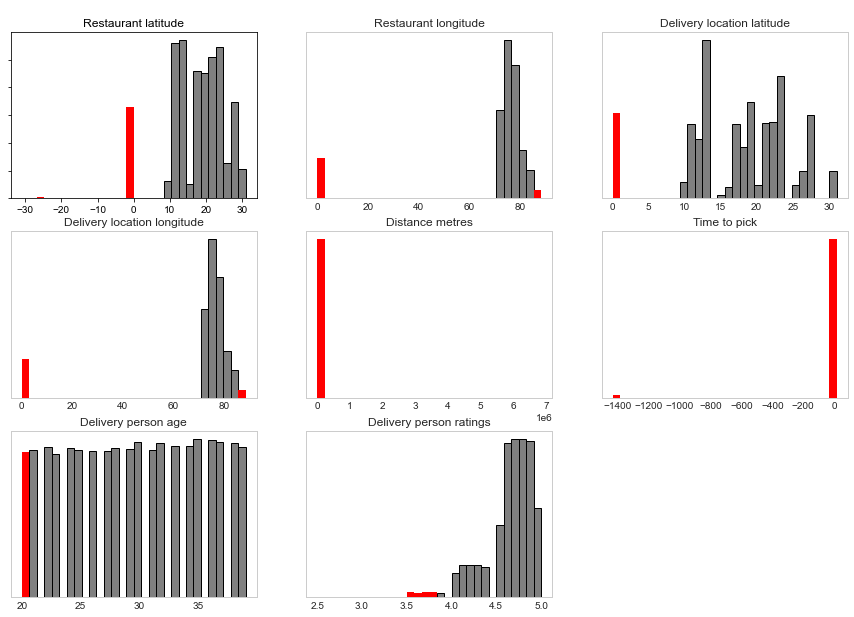

In [14]:
hist_plots(ab_food_delivery, ['restaurant_latitude', 'restaurant_longitude'
                             ,'delivery_location_latitude', 'delivery_location_longitude'
                             , 'distance_metres', 'time_to_pick'
                             , 'delivery_person_age', 'delivery_person_ratings'], scale_plots=1.3)

__There are some incorrect values in the data. At first, there is a cluster in geodata around the value 0, and it looks like an incorrect value. We have to remove these values. Also in the time_to_pick column, almost all the values are centered around the value 0, and a very small number of values have an excess value of about -1400__

In [15]:
ab_food_delivery = ab_food_delivery\
.query("restaurant_latitude > 0 & restaurant_longitude > 0 & delivery_location_latitude > 0 & delivery_location_longitude > 0 & time_to_pick > -10")


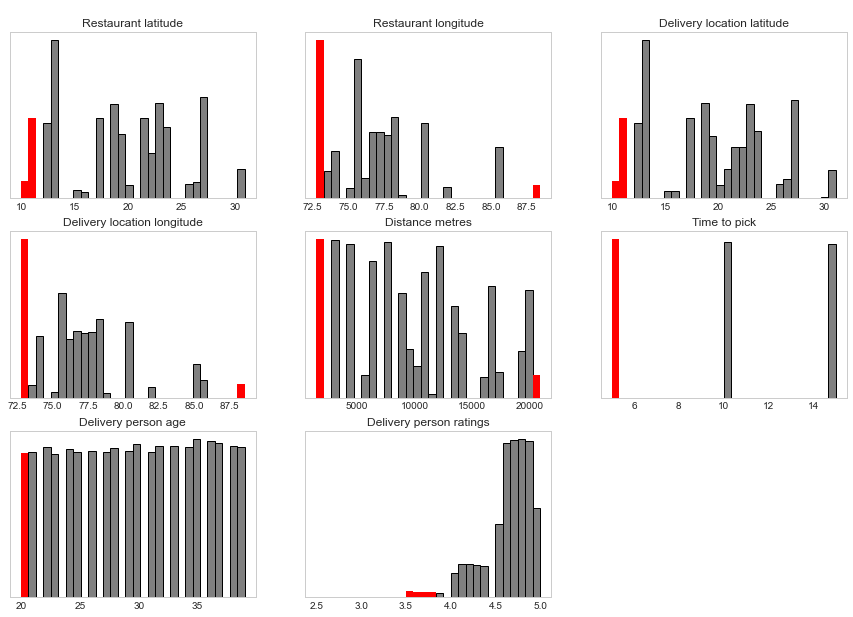

In [16]:
hist_plots(ab_food_delivery, ['restaurant_latitude', 'restaurant_longitude'
                             ,'delivery_location_latitude', 'delivery_location_longitude'
                             , 'distance_metres', 'time_to_pick'
                             , 'delivery_person_age', 'delivery_person_ratings'], scale_plots=1.3)

__Now, it looks like continuous data can be transformed to categorycal d-type__

In [17]:
# gathering features we interested in
ab_delivery_corrected = ab_food_delivery[['delivery_person_age', 'delivery_person_ratings',
                                          'weatherconditions', 'road_traffic_density',
                                          'vehicle_condition', 'type_of_order', 'type_of_vehicle',
                                          'multiple_deliveries', 'festival', 'city',
                                          'distance_metres', 'time_to_pick', 'time_taken_min']]

# transform discret and continuous data to categorical
ab_delivery_corrected.delivery_person_age = pd.cut(ab_delivery_corrected.delivery_person_age,
                                            ab_delivery_corrected.delivery_person_age.quantile([0.0, 0.33, 0.66, 1.0]).to_list(), 
                                            right=True,
                                            labels=['young', 'midage', 'adult'], include_lowest=True)
ab_delivery_corrected.delivery_person_ratings = pd.cut(ab_delivery_corrected.delivery_person_ratings,
                                            [0.0, 4.0, 4.5, 5.0], 
                                            right=True,
                                            labels=['low', 'middle', 'high'], include_lowest=True)
ab_delivery_corrected.distance_metres = pd.cut(ab_delivery_corrected.distance_metres,
                                        ab_delivery_corrected.distance_metres.quantile([0.0, 0.33, 0.66, 1.0]).to_list(), 
                                        right=True,
                                        labels=['small', 'mid', 'high'], include_lowest=True)
ab_delivery_corrected.time_to_pick = np.select([(ab_delivery_corrected.time_to_pick == 5.0),
                                               (ab_delivery_corrected.time_to_pick == 10.0),
                                               (ab_delivery_corrected.time_to_pick == 15.0)], 
                                               ['small_time', 'mid_time', 'long_time'])
ab_delivery_corrected.vehicle_condition = np.select([(ab_delivery_corrected.vehicle_condition == 0),
                                               (ab_delivery_corrected.vehicle_condition == 1),
                                               (ab_delivery_corrected.vehicle_condition == 2)], 
                                               ['bad', 'mid', 'good'])
ab_delivery_corrected['multiple_deliveries'] = ab_delivery_corrected['multiple_deliveries'].astype('int').astype('str')

ab_delivery_corrected = ab_delivery_corrected[ab_delivery_corrected.type_of_vehicle != 'electric_scooter']

__So, let's take a look on the data visualizing it using barplot__

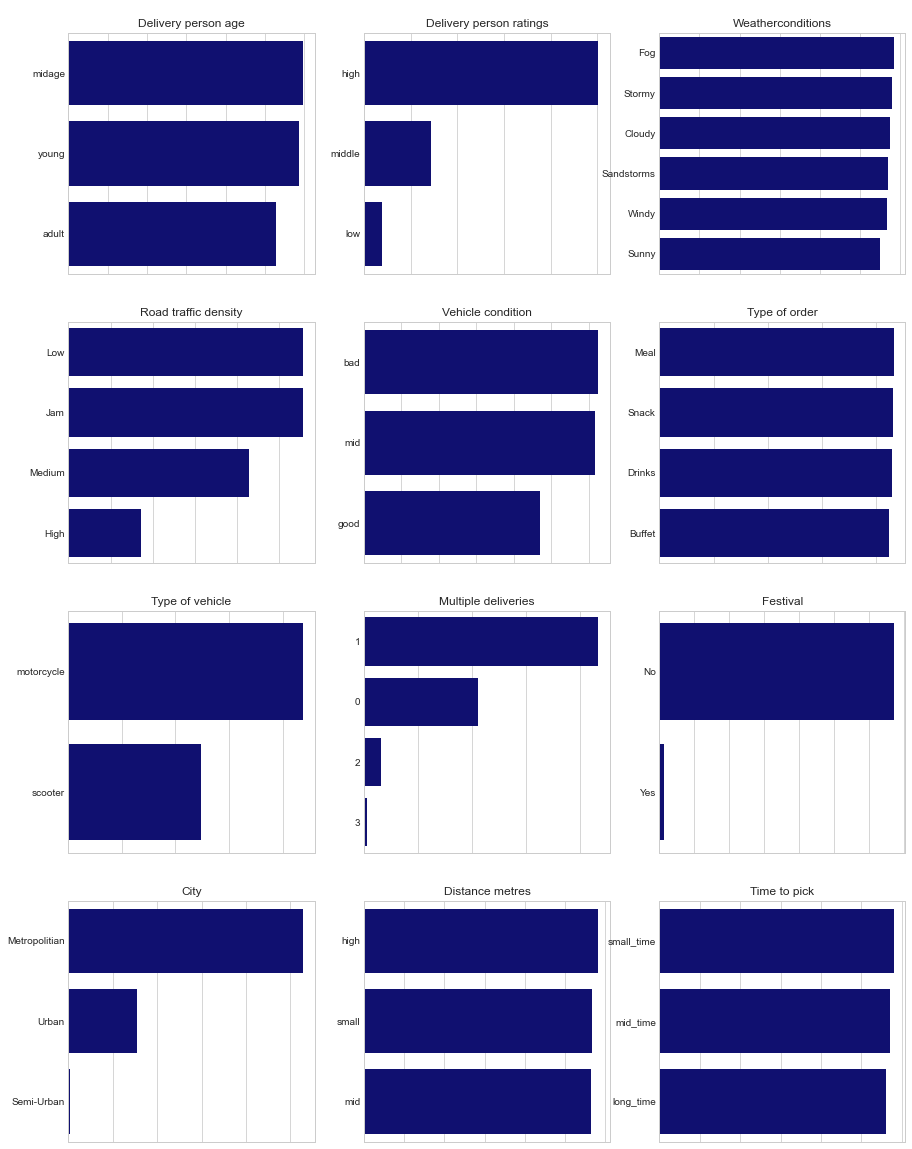

In [18]:
bar_plots(df=ab_delivery_corrected.iloc[:,:-1])

* The type of the order hardly changes the time of delivery (there is no difference whether a snack or a drink carrier delivers). So, we can remove the type_of_order column from the resulting dataframe.
* Also, almost all values in the column Festival is 'No'. In addition, probability density distribution of 'No' and 'Yes' values are the same (checked). So, we can delete this column too.
* Moreover, the values 'Semi-Urban' in the City column and '3' in the Multiple deliveries column are extremly rare. I want to drop this values in order to reduse the noice in the data and doing the data more convenient to process. 

In [19]:
ab_delivery_corrected = ab_delivery_corrected.drop(columns='type_of_order')
ab_delivery_corrected = ab_delivery_corrected[(ab_delivery_corrected.city != 'Semi-Urban')
                                              & (ab_delivery_corrected.multiple_deliveries != '3')].reset_index(drop=True)

__And the final version of the source data (the population, in this case)__

In [20]:
ab_delivery_corrected.head(3)

,delivery_person_age,delivery_person_ratings,weatherconditions,road_traffic_density,vehicle_condition,type_of_vehicle,multiple_deliveries,festival,city,distance_metres,time_to_pick,time_taken_min
0,adult,high,Sunny,High,good,motorcycle,0,No,Urban,small,long_time,24.0
1,adult,middle,Stormy,Jam,good,scooter,1,No,Metropolitian,high,small_time,33.0
2,young,middle,Sandstorms,Low,bad,motorcycle,1,No,Urban,small,long_time,26.0


In [21]:
get_info(ab_delivery_corrected)

,col_name,dtype,missing_values,unique_vals,total_vals
0,delivery_person_age,object,0,3,33847
1,delivery_person_ratings,object,0,3,33847
2,weatherconditions,object,0,6,33847
3,road_traffic_density,object,0,4,33847
4,vehicle_condition,object,0,3,33847
5,type_of_vehicle,object,0,2,33847
6,multiple_deliveries,object,0,3,33847
7,festival,object,0,2,33847
8,city,object,0,2,33847
9,distance_metres,object,0,3,33847


<hr>

## <span class="mark">A/B - test</span>

The next step is making samples. The  A group will be a control group (no changes made) and it will include only motorcycle vehicle type. The B group (a treatment group) differs from A in the only one feature (scooters vehicle type). We'll make a stratified sample (very basic stratification). After that we'll explore probability density distribution type and depending on type of distribution choose statistical method to compare A and B groups.


So let's create a code that creates a stratified sample. First we have to assign a hash key to each unique combination of the selected parameters and calculate the total proportion for each hash. After that, using the calculated proportion, we will extract the stratified sample. 

In [22]:
# create the dataframe including only motorcycle type_of_vehicle
moto = ab_delivery_corrected[ab_delivery_corrected.type_of_vehicle == 'motorcycle'].drop(columns='type_of_vehicle')

# create the dataframe including only scooter type_of_vehicle
scooter = ab_delivery_corrected[ab_delivery_corrected.type_of_vehicle == 'scooter'].drop(columns='type_of_vehicle')    

In [23]:
# hash for unique combs
moto['hash'] = moto.iloc[:,1:-1].apply(lambda x: hash(tuple(x)), axis=1)
scooter['hash'] = scooter.iloc[:,1:-1].apply(lambda x: hash(tuple(x)), axis=1)

It's trick to make our data similar. And since the data has been hashed we don't need anymore the rest columns and we can remove it.

In [24]:
unique_hash_scooter = scooter.hash.unique()
unique_hash_moto = moto.hash.unique()
moto_hashed = moto.query("hash in @unique_hash_scooter").reset_index(drop=True)[['hash', 'time_taken_min']]
scooter_hashed = scooter.query("hash in @unique_hash_moto").reset_index(drop=True)[['hash', 'time_taken_min']]
# check
moto_hashed.hash.nunique() == scooter_hashed.hash.nunique()

True

__Probability density distribution__

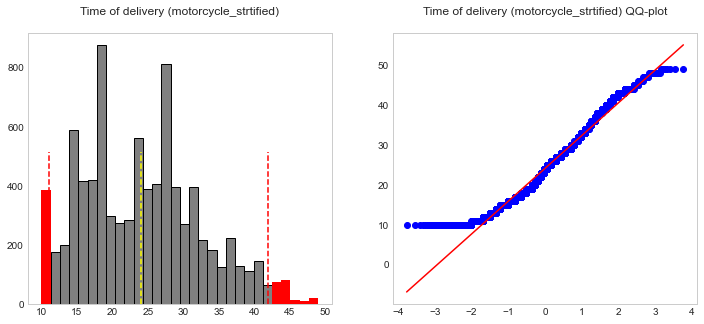

Time of delivery (motorcycle_strtified) has not normal probability density distribution
 Shapiro test p-val 5.373383666474765e-37
 Dagostino p-val 7.513228903601054e-76


False

In [25]:
density_distribution(moto_hashed.time_taken_min, plot_title='Time of delivery (motorcycle_strtified)')

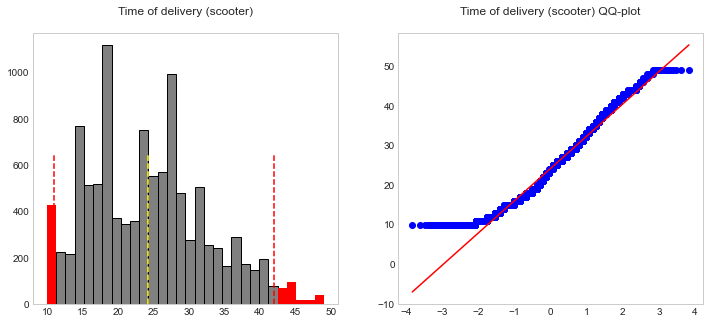

Time of delivery (scooter) has not normal probability density distribution
 Shapiro test p-val 1.5525546205640378e-40
 Dagostino p-val 5.198082029481808e-93


False

In [26]:
density_distribution(scooter_hashed.time_taken_min, plot_title='Time of delivery (scooter)')

So now we've got an idea about the distribution of data and it's nature. Further we will occure statistical tests to figure out is it statistically signficant difference in time_to_take parameter depending on the type_of_vehicle. 

It's obvious the distribution is not normal but it has similar shape for the groups. So, since parametric tests require a normal distribution of data, we will apply the non-parametric test of Mann-Whitney to figure out is it any dependence between samples.

__Extracting samples__

In [27]:
# function to extract stratified samples from a population
def strat_sampling(population_A, population_B, sample_size):
    population_A = population_A.sort_values(by='hash', ascending=False).reset_index(drop=True)
    population_B = population_B.sort_values(by='hash', ascending=False).reset_index(drop=True)
    weights = population_A.groupby(by='hash', as_index=False)\
                          .apply(lambda x: len(x)/len(population_A))\
                          .rename(columns={None: 'weight'})
    
    population_A['weight'] = ((population_A.merge(weights, how='left', on='hash')['weight'])
                              / (population_A.merge(weights, how='left', on='hash')['weight'].sum()))
    
    population_B['weight'] = ((population_B.merge(weights, how='left', on='hash')['weight'])
                              / (population_B.merge(weights, how='left', on='hash')['weight'].sum()))

    A_group = population_A.sample(sample_size, weights=population_A.weight)[['hash', 'time_taken_min']]
    B_group = population_B.sample(sample_size, weights=population_B.weight)[['hash', 'time_taken_min']]
        
    return {'A_group': A_group,
            'B_group': B_group}

In [29]:
# function to determine a sample size of nonparametric statistical test using the numeric Monte-Carlo method
def nonparam_sample_size(data_column, calculations=1000, alpha=0.05, lifts=np.arange(1, 1.02, 0.01), sizes=np.arange(500, 701, 200)):    

    res_df = pd.DataFrame() # calculation results are here

    for lift, n in tqdm(product(lifts, sizes)): 

        control = data_column.sample(n)

        # applying an effect
        test = control * lift 

        for _ in range(0, calculations):

            # A/B random grouping
            is_control = binom.rvs(1, 0.5, size=n) 

            # count p-value
            _, p = mannwhitneyu(control[is_control == True], test[is_control == False]) 

            # append result to df
            res_df = res_df.append({"lift": f'{int((lift-1.0)*100)}%', 
                                    "sample_size": n, "pvalue": p}, 
                                    ignore_index=True)

    result = res_df.groupby(["lift", "sample_size"]).apply(lambda x: sum(x['pvalue'] < alpha) / calculations)\
                   .to_frame().rename(columns={0: 'FPR/TPR'})
    return result      

__Suppose, the managers of the company consider it acceptable to increase the average delivery time maximum for 5%. We need to determine proper sample size to detect such an effect size. Since the data distribution is abnormal we will apply the numeric Monte-Carlo method to detect the required sample size. Since the maximum sample size is 8000 (moto_hashed.shape = 8564) it will be maximum of range in _sizes_ parameter of nonparam_sample_size func__

In [32]:
# it could be useful to apply multiprocessing in this case (do it later)
# this function is implemented for too long if it is evaluated in small steps
# so, i've occured it already and know we can detect 3% MDE using these data and higher threshold of the sample size
with timer('Sample size func'):
    ab_sample_size = nonparam_sample_size(moto_hashed.time_taken_min, 
                                          lifts=(1, 1.03), 
                                          sizes=np.arange(7000, 8001, 200))

0it [00:00, ?it/s]

[Sample size func] done in 161.195810 s


In [33]:
ab_sample_size

FPR/TPR
lift sample_size         
0%   7000           0.041
     7200           0.042
     7400           0.043
     7600           0.043
     7800           0.047
     8000           0.047
3%   7000           0.802
     7200           0.815
     7400           0.798
     7600           0.835
     7800           0.855
     8000           0.842

__So, let's summarize: we can detect 3% time_taken_min change with a p-value 0.05 and a test power 0.8 using a sample size of aproximately 7000 drivers. We can implement the test using these parameters now.__

In [60]:
# stratified sample
A_strat = strat_sampling(moto_hashed, scooter_hashed, 7000)['A_group']
B_strat = strat_sampling(moto_hashed, scooter_hashed, 7000)['B_group']

In [61]:
A_strat.time_taken_min.describe()

count    7000.000000
mean       23.667286
std         8.038468
min        10.000000
25%        17.000000
50%        23.000000
75%        29.000000
max        49.000000
Name: time_taken_min, dtype: float64

In [62]:
B_strat.time_taken_min.describe()

count    7000.000000
mean       23.691714
std         7.970537
min        10.000000
25%        17.000000
50%        23.000000
75%        29.000000
max        49.000000
Name: time_taken_min, dtype: float64

In [59]:
# -----------------------------------------------------------------------------------------------------------------------------

In [63]:
# function to conduct A/B-test using different methods
def ab_test(a_data,  # the feature of A group
            b_data,  # the feature of B group
            boot_it=1000, # number of bootstrap subsamples
            statistic = np.mean, # the bootstrap statistic we interested in 
            conf_level = 0.95, # the confidence level
            method = ['ttest', 'mannwhitneyu', 'bootstrap']
           ):
    
    
    plots = [a_data, b_data]
#   BOOTSTRAP
    if 'bootstrap' in method:
        boot_data = []
        for i in tqdm(range(boot_it)): # extracting subsamples
            samples_1 = a_data.sample(
                len(a_data), 
                replace = True # 
            ).values

            samples_2 = b_data.sample(
                len(b_data), 
                replace = True
            ).values

            boot_data.append(statistic(samples_1)-statistic(samples_2)) # calculate bootstrap statistic difference

        pd_boot_data = pd.Series(boot_data)

        left_quant = (1 - conf_level)/2
        right_quant = 1 - (1 - conf_level) / 2
        quants = pd_boot_data.quantile([left_quant, right_quant])

        p_1 = norm.cdf(
            x = 0, 
            loc = np.mean(boot_data), 
            scale = np.std(boot_data)
        )
        p_2 = norm.cdf(
            x = 0, 
            loc = -np.mean(boot_data), 
            scale = np.std(boot_data)
        )
        p_value = min(p_1, p_2) * 2
        
        pd_boot_data.name = 'Booted data'
        plots.append(pd_boot_data)
    
    # visualization    
    a_data.name = 'group A'
    b_data.name = 'group B'
    plt.figure(figsize=(17, 11))
    
    for i, data in enumerate(plots):
        i += 1
        ax = plt.subplot(3, 3, i)
        plot_title = '\n' + data.name
        quantiles = data.quantile([left_quant, right_quant])  
        
        _, _, bars = plt.hist(data, bins = 50)
        for bar in bars:
            if bar.get_x() <= quantiles.iloc[0] or bar.get_x() >= quantiles.iloc[1]:
                bar.set_facecolor('red')
            else: 
                bar.set_facecolor('grey')
                bar.set_edgecolor('black')

        plt.style.use('seaborn-whitegrid')
        plt.vlines(quantiles,ymin=0,ymax=(len(data)*0.06),colors='red',linestyle='--')
        plt.vlines(data.mean(),ymin=0,ymax=(len(data)*0.06),colors='yellow',linestyle='--')
        plt.xlabel(None)
        plt.ylabel(None)
        plt.grid(False)
        ax.set(yticklabels=[])
        plt.title(plot_title)
    plt.show()
    
    if 'mannwhitneyu' in method:
        mann_whitney = ss.mannwhitneyu(a_data, b_data)
    if 'ttest' in method:
        ttest = ss.ttest_ind(a_data, b_data)
    
    if 'bootstrap' in method: 
        if ((p_value < (1 - conf_level)) & (0.0 >= quants.min()) & (0.0 <= quants.max())):
            print(f'Bottstrap quants {quants.to_list()},\nBootstrap p-val {p_value}\n\n'
                  f'WE HAVE THE REASON TO REJECT THE NULL HYPOTESYS RELYING ON BOOTSTRAP\n\n')
        else:
            print(f'Bottstrap quants {quants.to_list()},\nBootstrap p-val {p_value}\n\n'
                  f'WE HAVE NOT THE REASON TO REJECT THE NULL HYPOTESYS RELYING ON BOOTSTRAP\n\n')
    if 'mannwhitneyu' in method:
        if (mann_whitney[1] < (1 - conf_level)):
            print(f'Mann-Whitney p-val {mann_whitney[1]}\n\nWE HAVE THE REASON TO REJECT THE NULL HYPOTESYS RELYING ON MANN-WHITNEY\n\n')
        else:
            print(f'Mann-Whitney p-val {mann_whitney[1]}\n\nWE HAVE NOT THE REASON TO REJECT THE NULL HYPOTESYS RELYING ON MANN-WHITNEY\n\n')
    if 'ttest' in method:
        if (ttest[1] < (1 - conf_level)):
            print(f't-test p-val {ttest[1]}\n\nWE HAVE THE REASON TO REJECT THE NULL HYPOTESYS RELYING ON T-TEST\n\n')
        else:
            print(f't-test p-val {ttest[1]}\n\nWE HAVE NOT THE REASON TO REJECT THE NULL HYPOTESYS RELYING ON T-TEST\n\n')
        
#     return {
#             'bootstrap_quants': quants,
#             'bootsrap_p_value': p_value,
#             'mann_whitney_p_value': mann_whitney[1],
#             'ttest_p_value': ttest[1]
#             }

  0%|          | 0/1000 [00:00<?, ?it/s]

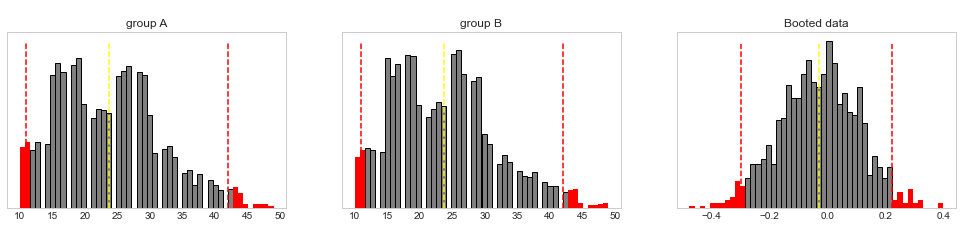

Bottstrap quants [-0.29779999999999934, 0.22394285714285608],
Bootstrap p-val 0.827922225479227

WE HAVE NOT THE REASON TO REJECT THE NULL HYPOTESYS RELYING ON BOOTSTRAP


Mann-Whitney p-val 0.9461594350132597

WE HAVE NOT THE REASON TO REJECT THE NULL HYPOTESYS RELYING ON MANN-WHITNEY




In [64]:
ab_test(A_strat.time_taken_min, B_strat.time_taken_min, method=['mannwhitneyu', 'bootstrap'])

<hr>

## <span class="mark">Conclusion</span>

__We have no reason to reject the null hypotesis of a statistically significant difference in time_taken_min depending on the type of vehicle used by drivers (with MDE level 3%). Perhaps this difference exists, but we need a larger sample size to detect it and it's size precisely less than 3%.__

<div class="burk">
<hr>
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
<hr></div><i class="fa fa-lightbulb-o "></i>